# OsuLearn
##### Machine Learning para jogar mapas de osu!

^^^

Isso aí, tô sem mais nada pra fazer, bora criar uma IA que joga osu! )o)

## Importar umas coisas...

In [1]:
# Machine Learning
import tensorflow as tf
import keras

import numpy as np
import pandas as pd

# Plotagem
import matplotlib.pyplot as plt

# Utilidades
import os
import re
import math
import glob

from importlib import reload

# Lógica do osu!
import osu.rulesets.beatmap
import osu.rulesets.replay

import osulearn

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Constantes

Aqui tem uns caminhos para os arquivos que precisamos:

In [2]:
# Pasta do osu!
OSU_FOLDER = "C:\\" + os.path.join("Program Files (x86)", "Jogos", "osu!")

## Dados para treinamento...

In [3]:
def load_replay_files():
    replay_training_set = []
    pattern = os.path.join(OSU_FOLDER, "Replays", "* Osu*.osr")
    _cache = {}
    for replay_file in glob.glob(pattern):
        try:
            info = re.search(r"([^\\/]+) \- (.+ \- .+) \[(.+)\] \((.+)\)", replay_file)
            player, bmap, diff, date = info[1], info[2], info[3], info[4]
            print(player, bmap, diff, date)

            file = "*" + glob.escape(bmap) + "*" + glob.escape("[" + diff + "]") + ".osu"
            pattern = os.path.join(OSU_FOLDER, "Songs", "**", file)

            if pattern in _cache:
                beatmap_file = _cache[pattern]
            else:
                beatmap_file = glob.glob(pattern)

            if len(beatmap_file) > 0:
                _cache[pattern] = beatmap_file
                beatmap = osu.rulesets.beatmap.load(beatmap_file[0])
                if re.search("v14", beatmap.format_version) != None:
                    replay = osu.rulesets.replay.load(replay_file)

                    if not (replay.mods & 0x10 or replay.mods & 0x40):
                        replay_training_set.append([beatmap, replay])
                        print("OK", len(replay_training_set) - 1)
                    else:
                        print("Replay uses DT or HR. Those mods are not supported yet.")
                else:
                    print("Wrong format version")
            else:
                print("Beatmap file not found")
        except Exception as e:
            print("Failed:", e)
        print()
            
        
    return replay_training_set

In [4]:
reload(osulearn)
reload(osu.rulesets.replay)
reload(osu.rulesets.beatmap)

try:
    X = np.load('.data/input_data.npy')
except:
    try:
        replay_training_set
    except NameError:
        replay_training_set = load_replay_files()
    
    print("Processing Input Data...")
    X = osulearn.create_training_data(replay_training_set)
    print()
    np.save('.data/input_data.npy', X)
    
try:
    y = np.load('.data/target_data.npy')
except:
    try:
        replay_training_set
    except NameError:
        replay_training_set = load_replay_files()   
    
    print("Processing Target Data...")
    y = osulearn.create_target_data(replay_training_set)
    
    np.save('.data/target_data.npy', y)

print(X.shape, y.shape)

BzMasked (K)NoW_NAME - Freesia Expert 2018-12-30
OK 0

BzMasked (K)NoW_NAME - Freesia Expert 2018-12-31
OK 1

BzMasked 3R2 - Bunny Panic!!! Bunny Extinction 2018-12-30
OK 2

BzMasked 55x55 - MRAZ' (feat. Larin) Insane 2018-12-30
OK 3

BzMasked Aimer with chelly (EGOIST) - ninelie (REDSHiFT x Vesuvia remix) Daydream 2018-06-01
OK 4

BzMasked Aiobahn & Yunomi - Makuramoto ni Ghost NiNo's Together 2018-03-31
Failed: Not a osu!std replay

BzMasked Aitsuki Nakuru - Monochrome Butterfly Extra 2017-09-09
OK 5

BzMasked Aitsuki Nakuru - Monochrome Butterfly Mysterious 2017-08-04
OK 6

BzMasked Aitsuki Nakuru - Presenter Noel 2019-01-01
OK 7

BzMasked Alex Gaudino feat. Crystal Waters - Destination Calabria Destination Unknown 2017-11-25
OK 8

BzMasked Alex Gaudino feat. Crystal Waters - Destination Calabria Destination Unknown 2017-12-01
OK 9

BzMasked Amidst - Phantasy NYA! 2018-12-30
OK 10

BzMasked Analogfish - Speed schoolboy's Extra 2019-01-01
OK 11

BzMasked Asterisk - Ren-chon no Drum '

OK 95

BzMasked Natsume Chiaki - Hanairo Biyori Awaken's Challenge 2019-01-02
Wrong format version

BzMasked Nekomata Gekidan - AsiaN distractive Orientalism 2019-01-02
OK 96

BzMasked Nhato - Ibuki Second Wind 2017-09-17
OK 97

BzMasked nowisee - confusion Shira's Expert 2018-09-26
OK 98

BzMasked O2i3 - TSLove Extra 2019-01-02
OK 99

BzMasked Orangestar - Kimi no Yozora Shoukaihan Starlight 2019-01-02
OK 100

BzMasked OSTER Project feat. Nanahira - Napo Napo Ritaan Macchi Napoli-tan owo 2019-01-01
OK 101

BzMasked Panda Eyes & Teminite - Highscore Extra 2017-12-02
OK 102

BzMasked Panda Eyes & Teminite - Highscore Game Over 2019-01-01
OK 103

BzMasked Panda Eyes - ILY Fanteer's Final Level 2018-12-30
OK 104

BzMasked RADWIMPS - Yume Tourou Extra Taki 2019-01-02
OK 105

BzMasked Razihel & Virtual Riot - One For All, All For One Together We've Fallen 2019-01-02
OK 106

BzMasked Reji - A Young Girl, So Vivid in the Night Honest or Liar 2018-02-11
OK 107

BzMasked Release hallucination -

Zen Zen Zense
Bang Bang
Bang Bang
Harumachi Clover
Harumachi Clover
Shoujo to Ougonryuu no Monogatari
Uraomote Lovers
Kawaiku Naritai (Short Ver.)
Coloring
True truly love
None
Hyadain's Jojo Yujo
Transform (Original Mix)
Make a Move (Speed Up Ver.)
Warriors
Uta
Yomi yori Kikoyu, Koukoku no Tou to Honoo no Shoujo.
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Endless Tewi-ma Park
Fatima (TV Size)
Hammer o Denpa Song ni Shitemita
Flamingo (WTN3 Remix)
STARRING STAR
Smiling (Speed Up Ver.)
EGOiSTiC SHOOTER
Heart no Atoaji
Heart no Atoaji
ILIAS
Caught Fire (feat. Ashley Lawless)
Leave It All To Me
Paradisus-Paradoxum
Milk Crown on Sonnetica
A

## Modelo de rede neural

Agora começa a festa...

In [5]:
reload(keras)
reload(tf)

from keras.models import Model, Sequential
from keras.layers import    Dense, Dropout, Activation,\
                            CuDNNLSTM, CuDNNGRU, concatenate,\
                            Input, Reshape, Conv1D, UpSampling1D,\
                            GaussianNoise

REPLAY_FEATURES = ['x', 'y']
MAP_FEATURES = ['x', 'y', 'time_left', 'is_slider', 'is_spinner']

map_input = Input(shape=(X.shape[1], X.shape[2]), name='map_info')

out = CuDNNLSTM(16, kernel_initializer='normal', return_sequences=True)(map_input)
out = Dense(64, kernel_initializer='normal', activation='linear')(out)
out = Dense(128, kernel_initializer='normal', activation='linear')(out)
out = GaussianNoise(0.1)(out)
out = Dense(64, kernel_initializer='normal', activation='linear')(out)
out = Dense(len(REPLAY_FEATURES), kernel_initializer='normal', activation='linear')(out)

model = Model(inputs=map_input, outputs=out)

model.compile(optimizer='adam', loss='mae')
model.summary()

try:
    model.load_weights(".data/model.hdf5")
except Exception as e:
    print()
    print("Failed to load weights: ", e)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
map_info (InputLayer)        (None, 1024, 5)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 1024, 16)          1472      
_________________________________________________________________
dense_1 (Dense)              (None, 1024, 64)          1088      
_________________________________________________________________
dense_2 (Dense)              (None, 1024, 128)         8320      
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 1024, 128)         0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024, 64)          8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1024, 2)           130       
Total para

In [6]:
def plot_info(compare):
    %matplotlib inline
    
    plt.ylim((-1, 1))
    for data in compare:
        plt.plot([(x, y) for x, y in data])
    #for data in compare:
    #    plt.plot([(y) for x, y in data])
    plt.show()

In [7]:
from random import randint
from sklearn.model_selection import train_test_split

ITERATIONS = 8
EPOCHS = 16

try:
    loss
except NameError:
    loss = []
    
for i in range(ITERATIONS):
    print("-" * 80)
    print("Iteration #%d" % (i + 1))
    print("-" * 80)
    print()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randint(0, 100))
    h = model.fit(X_train, y_train, batch_size=len(X_train), epochs=EPOCHS, verbose=1)
    loss += h.history['loss']
    print()

model.save_weights(".data/model.hdf5")

--------------------------------------------------------------------------------
Iteration #1
--------------------------------------------------------------------------------

Epoch 1/16
884/884 [==============================] - 8s 9ms/step - loss: 0.0462
Epoch 2/16
884/884 [==============================] - 1s 669us/step - loss: 0.0679
Epoch 3/16
884/884 [==============================] - 1s 643us/step - loss: 0.0478
Epoch 4/16
884/884 [==============================] - 1s 634us/step - loss: 0.0555
Epoch 5/16
884/884 [==============================] - 1s 656us/step - loss: 0.0601
Epoch 6/16
884/884 [==============================] - 1s 632us/step - loss: 0.0555
Epoch 7/16
884/884 [==============================] - 1s 631us/step - loss: 0.0491
Epoch 8/16
884/884 [==============================] - 1s 635us/step - loss: 0.0477
Epoch 9/16
884/884 [==============================] - 1s 645us/step - loss: 0.0524
Epoch 10/16
884/884 [==============================] - 1s 627us/step - loss: 0.

Epoch 7/16
884/884 [==============================] - 1s 647us/step - loss: 0.0462
Epoch 8/16
884/884 [==============================] - 1s 566us/step - loss: 0.0462
Epoch 9/16
884/884 [==============================] - 0s 538us/step - loss: 0.0462
Epoch 10/16
884/884 [==============================] - 1s 670us/step - loss: 0.0462
Epoch 11/16
884/884 [==============================] - 1s 656us/step - loss: 0.0462
Epoch 12/16
884/884 [==============================] - 0s 536us/step - loss: 0.0462
Epoch 13/16
884/884 [==============================] - 0s 529us/step - loss: 0.0462
Epoch 14/16
884/884 [==============================] - 0s 544us/step - loss: 0.0462
Epoch 15/16
884/884 [==============================] - 0s 525us/step - loss: 0.0461
Epoch 16/16
884/884 [==============================] - 0s 533us/step - loss: 0.0461

--------------------------------------------------------------------------------
Iteration #7
--------------------------------------------------------------------

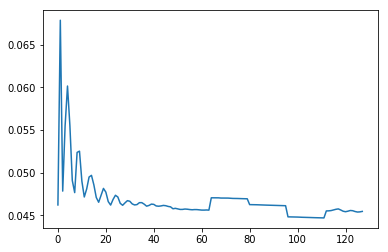

In [11]:
%matplotlib inline

plt.plot(loss)
plt.show()

0


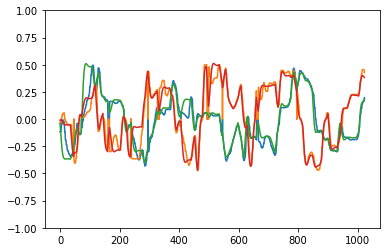

1


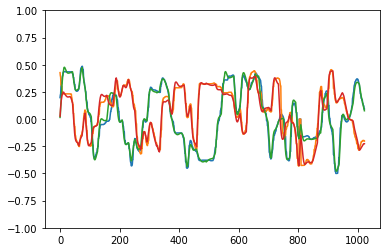

2


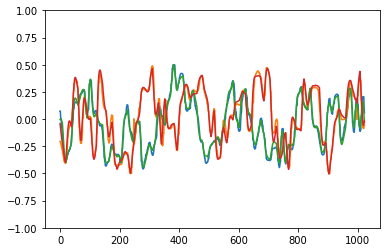

3


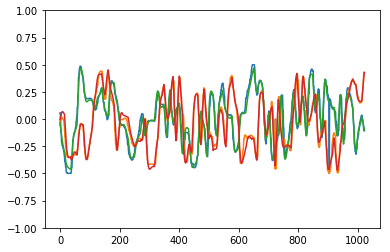

4


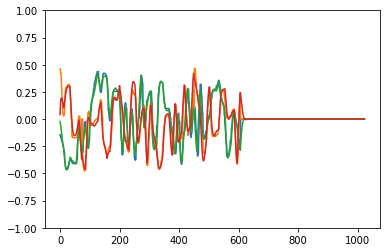

5


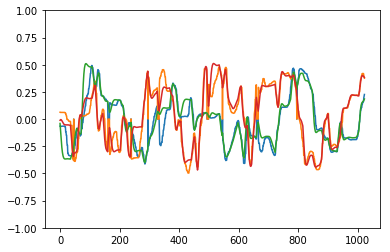

6


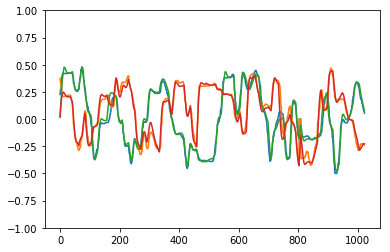

7


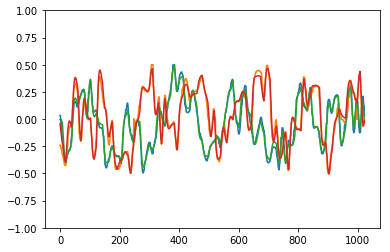

8


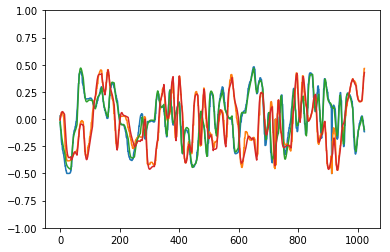

9


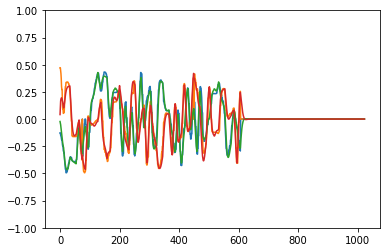

10


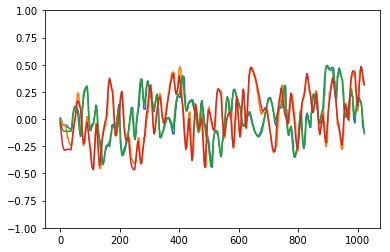

11


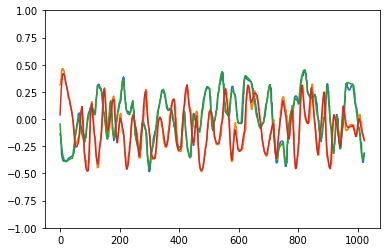

12


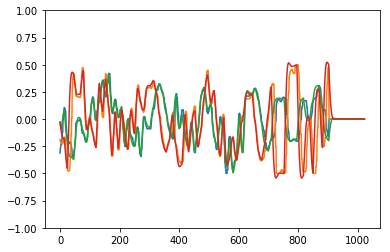

13


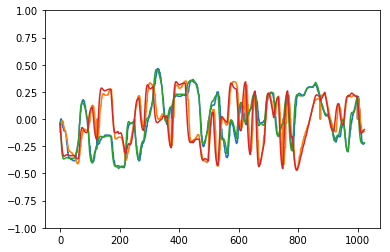

14


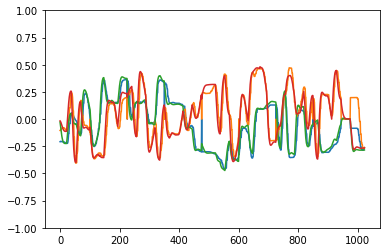

15


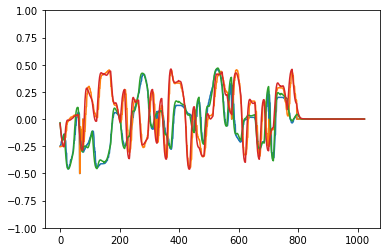

16


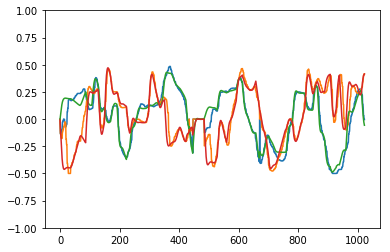

17


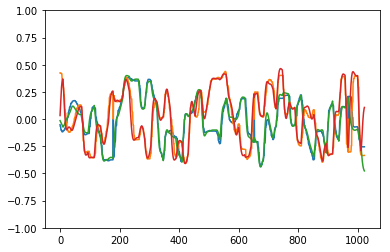

18


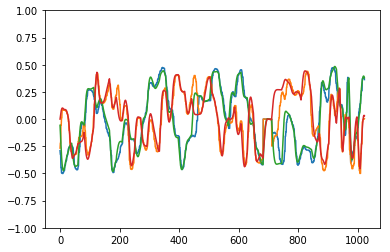

19


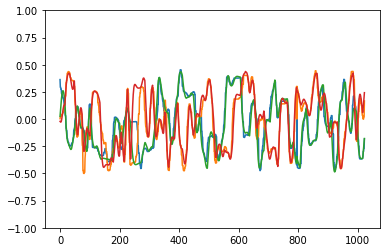

20


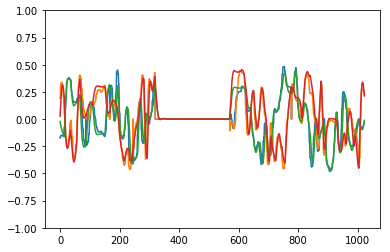

21


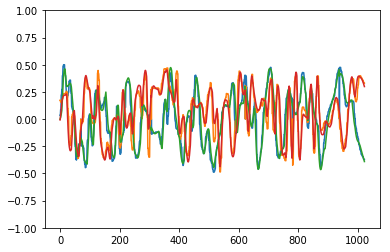

22


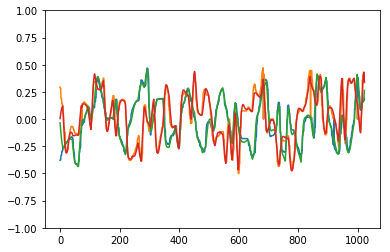

23


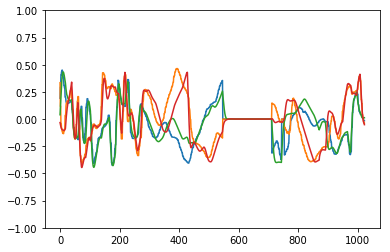

24


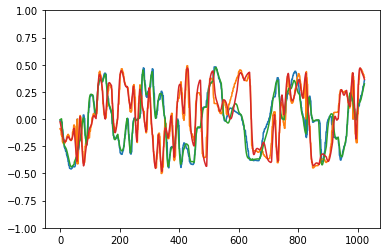

25


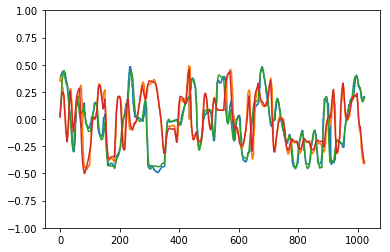

26


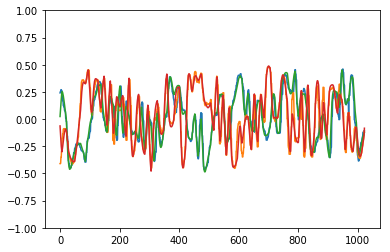

27


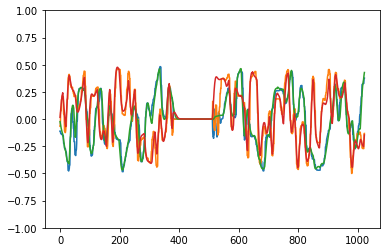

28


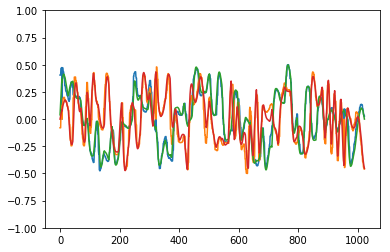

29


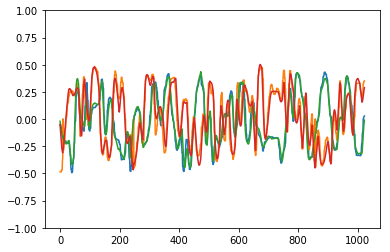

30


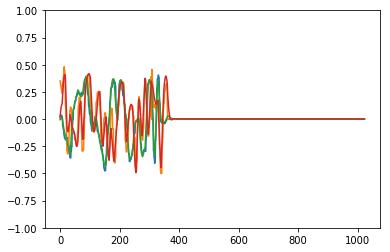

31


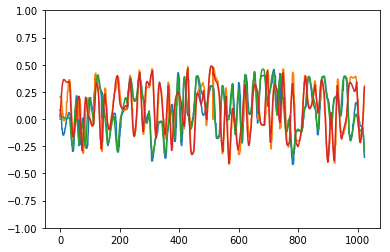

32


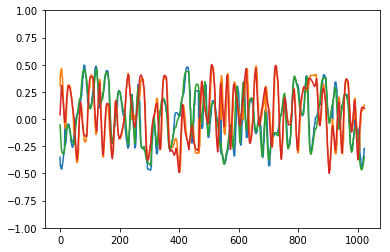

33


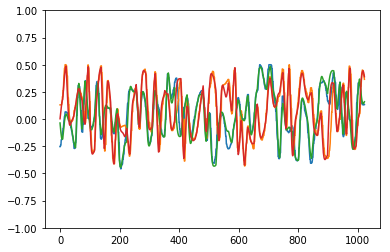

34


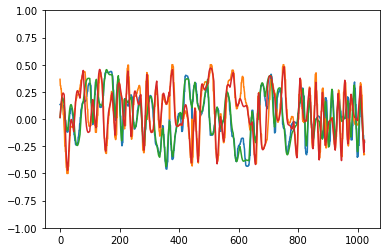

35


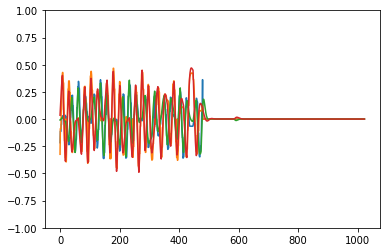

36


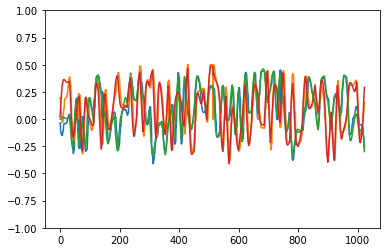

37


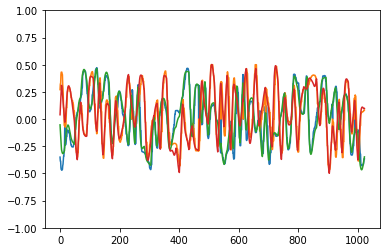

38


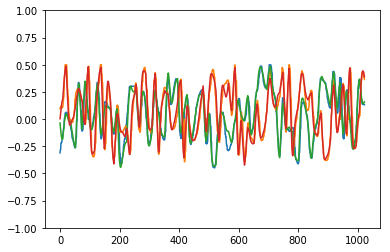

39


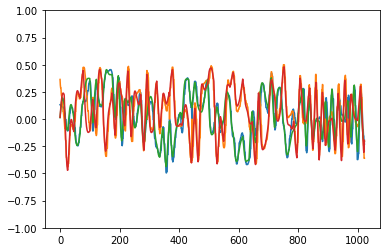

40


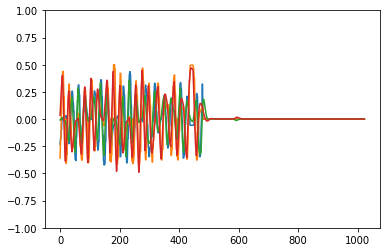

41


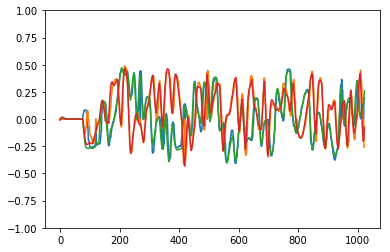

42


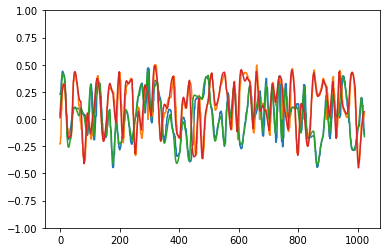

43


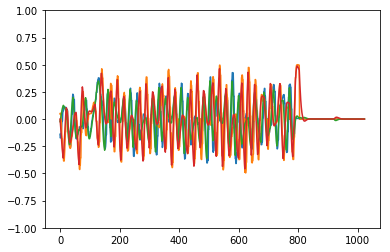

44


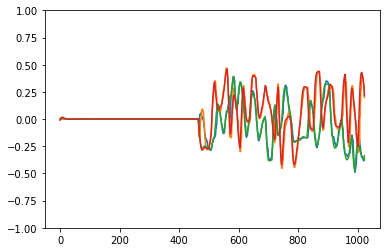

45


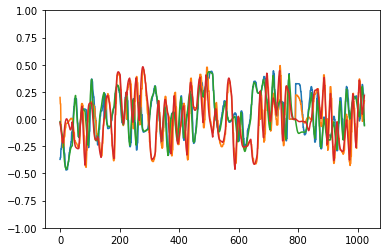

46


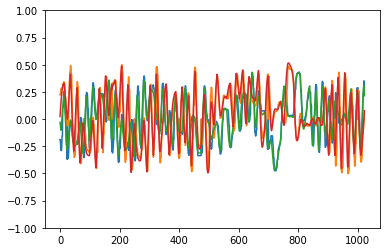

47


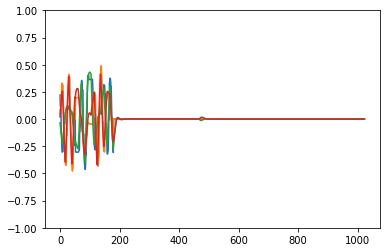

48


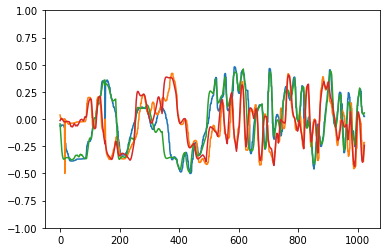

49


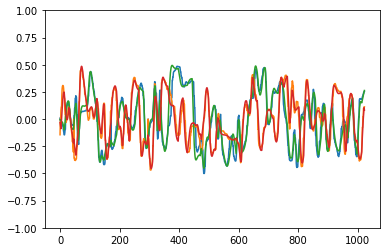

In [12]:
predicted = model.predict(X)

for i in range(50):#len(predicted)):
    print(i)
    plot_info([y[i], predicted[i]])

Uta


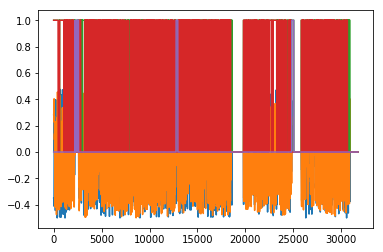

Done.


In [13]:
reload(osulearn)

BEATMAPS_FOLDER = 'C:\\Program Files (x86)\\Jogos\\osu!\\Songs\\'
#BEATMAP = glob.glob(BEATMAPS_FOLDER + "\\**\\*Kami no Kotoba*byfar*Voice of God*.osu")[0]
#BEATMAP = glob(BEATMAPS_FOLDER + "\\**\\*My Love*Insane*.osu")[0]
BEATMAP = glob.glob(BEATMAPS_FOLDER + "\\**\\*Uta*Himei*.osu")[0]
#BEATMAP = glob.glob(BEATMAPS_FOLDER + "\\**\\*DAYBREAK*Horizon[]]*.osu")[0]

beatmap = osu.rulesets.beatmap.load(BEATMAP)

xx = osulearn.create_training_data([(beatmap, None)])

plt.plot(np.concatenate(xx))
plt.show()

predicted = model.predict(xx)

np.save('osu/replay.npy', np.concatenate(predicted))
print("Done.")